## Importando bibliotecas

### Baixando bibliotecas necessárias e importando os dados

In [ ]:
#!pip install optuna
#!pip install scikit-learn
#!pip install sklearn
#!pip install ucimlrepo
#!pip install torch

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
# Import needed libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from sklearn.pipeline import Pipeline # Importing the Pipeline class
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Fetch dataset from UCI Repository
from ucimlrepo import fetch_ucirepo
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original
import optuna
from optuna.samplers import GPSampler
import sklearn
import sklearn.ensemble
from sklearn import datasets

### Pré-processamento dos dados

In [ ]:
# ---------------------------------------------------------------------------- #
#                                PRE-PROCESSING                                #
# ---------------------------------------------------------------------------- #

# --------------------------------- SETTINGS --------------------------------- #
Normalize = False
PC_Features = True
Test_Size = 0.2
Random_Seed = 82024
Torch = False

# Drop missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Binarize target
df.loc[df['num'] != 0, 'num'] = 1

# Define features and target vectors
X = df.iloc[:,:-1]
y = df['num']

# Normalize if requested
if (Normalize) or (PC_Features):
    int_features, cat_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'],\
    ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

    preprocessor = ColumnTransformer(
    transformers=[
        ('int', StandardScaler(), int_features),
        ('cat', OneHotEncoder(), cat_features)
    ])
    X = preprocessor.fit_transform(X)
else:
    X = X.values

# Apply PCA if requested
if PC_Features:
    pca = PCA(n_components=12)
    X = pca.fit_transform(X)

# Split train and test data
index = list(range(y.size))
train_index, test_index = train_test_split(index, test_size=Test_Size, random_state=Random_Seed)

train_X = X[train_index]
train_y = y.loc[train_index].values

test_X = X[test_index]
test_y = y.loc[test_index].values

# Convert to torch tensor if requested
if Torch:
    train_X, train_y, test_X, test_y = torch.tensor(train_X),
    torch.tensor(train_y), torch.tensor(test_X), torch.tensor(test_y)

## Modelo SVC classification SVM:

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.SVC(random_state=Random_Seed, probability = True)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.77
AUC-ROC: 0.87


### Definindo função objetivo

In [ ]:
def objective(trial):
      # Sugerindo os hiperparâmetros a serem otimizados
      C = trial.suggest_loguniform('C', 1e-5, 1e2)  # Faixa de valores para o parâmetro de regularização C
      kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Seleção do kernel
      gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Opções para o parâmetro gamma

      # Criando o modelo SVC com os parâmetros sugeridos
      clf = sklearn.svm.SVC(C=C, kernel=kernel, gamma=gamma)
      # Otimizando a média da validação cruzada
      return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

### Executando o optuna
Talvez alguns erros aparecem nas versões mais novas do optuna, podem ignorar.

In [ ]:
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

<ipython-input-60-075dcc0a778d>:1: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-17 19:00:52,700] A new study created in memory with name: no-name-5224a8a3-b051-4dab-956b-f8f655d12ee5
<ipython-input-59-0d1ecaeeb87e>:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-10-17 19:00:52,765] Trial 0 finished with value: 0.8901372354497354 and parameters: {'C': 0.012847926555751215, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8901372354497354.
<ipython-input-59-0d1ecaeeb87e>:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-10-17 19:00:52,811] Trial 1 finished with

### Mostrar melhor modelo

In [ ]:
trial = study.best_trial
print('ROC_AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

ROC_AUC: 0.9130373677248678
Best hyperparameters: {'C': 1.6146471311892094, 'kernel': 'linear', 'gamma': 'auto'}


### Visualizando otimização

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

### Rodando com os melhores hiperparâmetros

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.SVC(random_state=Random_Seed, C = 0.7983715645575858, kernel = 'sigmoid', gamma = 'scale', probability = True)

# Train model
#model.fit(train_X, train_y)

# Test model
#y_pred = model.predict(test_X)

#pred_probs = model.predict_proba(test_X)

# Evaluation:
#acc = accuracy_score(test_y, y_pred)
#roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
acc = cv_results['test_accuracy'].mean()
roc_auc = cv_results['test_roc_auc'].mean()

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

#Best hyperparameters: {'C': 0.7983715645575858, 'kernel': 'sigmoid', 'gamma': 'scale'}

Accuracy: 0.8315
AUC-ROC: 0.9113


## Modelo NuSVC classification SVM implementation:

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.NuSVC(random_state=Random_Seed, probability=True)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.75
AUC-ROC: 0.87


### Definindo função objetivo:

In [ ]:
def objective(trial):
      # Faixa de parâmetros para otimização
      nu = trial.suggest_float('nu', 0.1, 0.9, log=True)  # nu é um parâmetro entre 0 e 1
      kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])  # Tipo de kernel
      gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])  # Gamma para os kernels não lineares

      # Modelo NuSVC com os parâmetros sugeridos
      clf = sklearn.svm.NuSVC(nu=nu, kernel=kernel, gamma=gamma)

      try:
        # Otimizando a média da validação cruzada
        score = sklearn.model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=3).mean()
      except ValueError:
        # Return a low score if nu is infeasible
        #score = -1
        score = float('-inf')# for a more drastic penalty

      # Otimizando a média da validação cruzada
      return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

### Executando o Optuna:

In [ ]:
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

<ipython-input-63-075dcc0a778d>:1: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-17 19:03:00,404] A new study created in memory with name: no-name-08c51481-86c2-4c5a-85c3-d6cbd47db5c9
[I 2024-10-17 19:03:03,187] Trial 0 finished with value: 0.900256283068783 and parameters: {'nu': 0.7630674861374876, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.900256283068783.
[I 2024-10-17 19:03:03,242] Trial 1 finished with value: 0.5798197751322751 and parameters: {'nu': 0.10015334045863979, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.900256283068783.
[I 2024-10-17 19:03:03,319] Trial 2 finished with value: 0.895345568783069 and parameters: {'nu': 0.8252777348537341, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.900256283068783.
[I 2024-10-17 19:03:03,391] Trial 3 finished with value: 0.8441468253968255 and parameters: {'nu': 0.12827607813730413, 'kerne

### Mostrar melhor modelo

In [ ]:
trial = study.best_trial
print('ROC_AUC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

ROC_AUC: 0.9128472222222221
Best hyperparameters: {'nu': 0.43535275759217024, 'kernel': 'sigmoid', 'gamma': 'scale'}


### Visualizando a otimização

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

### Rodando com os melhores hiperparâmetros

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.NuSVC(random_state=Random_Seed, nu = 0.44292430998916865, kernel= 'sigmoid', gamma = 'scale', probability=True)


# Train model
#model.fit(train_X, train_y)

# Test model
#y_pred = model.predict(test_X)

#pred_probs = model.predict_proba(test_X)

# Evaluation:
#acc = accuracy_score(test_y, y_pred)
#roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

cv_results = cross_validate(model, X, y, scoring=['accuracy', 'roc_auc'])
acc = cv_results['test_accuracy'].mean()
roc_auc = cv_results['test_roc_auc'].mean()


print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

#'nu': 0.44292430998916865, 'kernel': 'sigmoid', 'gamma': 'scale'

Accuracy: 0.8314
AUC-ROC: 0.9115


## Modelo LinearSVC classification SVM implementation:

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.LinearSVC(random_state=Random_Seed, dual=False)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

# This module does not have a way to access probability
# pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
# roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.77
AUC-ROC: 0.87


### Definindo função objetivo:

In [ ]:
def objective(trial):
      # Sugestão de hiperparâmetros para otimização
      C = trial.suggest_loguniform('C', 1e-5, 1e2)  # Valor do parâmetro de regularização C
      max_iter = trial.suggest_int('max_iter', 100, 10000)  # Número máximo de iterações

      # Criando o pipeline com padronização e o modelo LinearSVC
      clf = Pipeline([
          ('scaler', StandardScaler()),  # Padronizando os dados
          ('svc', sklearn.svm.LinearSVC(C=C, max_iter=max_iter, dual=False))
      ])
      # Otimizando a média da validação cruzada
      return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

### Executando o Optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

<ipython-input-69-075dcc0a778d>:1: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-17 19:04:56,295] A new study created in memory with name: no-name-7429f5a8-7db1-4fc0-8b03-950c144ba033
<ipython-input-68-7e9345b44870>:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-10-17 19:04:56,357] Trial 0 finished with value: 0.9188078703703704 and parameters: {'C': 0.15366656402289625, 'max_iter': 3247}. Best is trial 0 with value: 0.9188078703703704.
<ipython-input-68-7e9345b44870>:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2024-10-17 19:04:56,402] Trial 1 finished with value: 0.91905588

### Mostra melhor modelo

In [ ]:
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

AUC-ROC: 0.9190558862433862
Best hyperparameters: {'C': 1.4276859883352893, 'max_iter': 8552}


### Visualizando a otimização

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

### Rodando com os melhores hiperparâmetros

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = svm.LinearSVC(random_state=Random_Seed, C = 1.4276859883352893, max_iter = 8552, dual=False)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

# This module does not have a way to access probability
# pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
# roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")


# Best hyperparameters: {'C': 1.4276859883352893, 'max_iter': 8552}

Accuracy: 0.7667
AUC-ROC: 0.9115


## Logistic Regression

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = LogisticRegression(random_state=Random_Seed)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

Accuracy: 0.80
AUC-ROC: 0.89


### Definindo função objetivo:

In [ ]:
def objective(trial):
      # Faixa de parâmetros para otimizar
      C = trial.suggest_loguniform('C', 1e-5, 1e2)  # Parâmetro de regularização
      solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])  # Solver

      # Suggest penalty separately for each solver to avoid dynamic value space
      if solver == 'liblinear':
          penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
      else:
          penalty = trial.suggest_categorical('penalty_other', ['l2', None])

      # Use the appropriate penalty based on the solver
      penalty = penalty if solver == 'liblinear' else penalty

      # Definindo o modelo de regressão logística
      clf = sklearn.linear_model.LogisticRegression(C=C, solver=solver, penalty=penalty, max_iter=1000)

      # Otimizando a média da validação cruzada
      return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

### Executando o Optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

<ipython-input-74-075dcc0a778d>:1: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-17 19:09:12,517] A new study created in memory with name: no-name-266b22ce-020e-451e-8c31-09a7893419c3
<ipython-input-73-46639e1d3b3c>:3: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1208: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

/usr/local/lib/python

### Mostra melhor modelo

In [ ]:
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

AUC-ROC: 0.9190724206349208
Best hyperparameters: {'C': 1.01119645325253, 'solver': 'saga', 'penalty_other': 'l2'}


### Visualizando a otimização

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

### Rodando com os melhores hipeparâmetros

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = LogisticRegression(C = 1.01119645325253, solver = 'saga', penalty= 'l2', random_state=Random_Seed)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

#Best hyperparameters: {'C': 1.01119645325253, 'solver': 'saga', 'penalty_other': 'l2'}

Accuracy: 0.80
AUC-ROC: 0.89


## Árvore de decisão

Accuracy: 0.67
AUC-ROC: 0.67


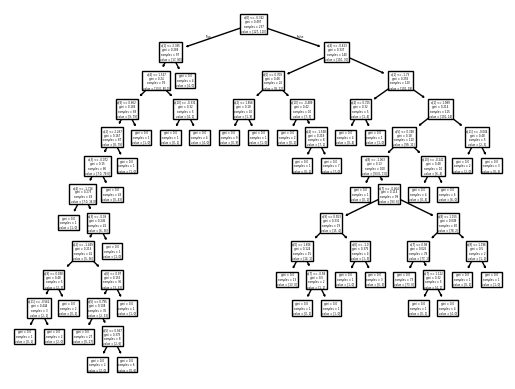

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = tree.DecisionTreeClassifier(random_state=Random_Seed)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

plot = tree.plot_tree(model)

### Definindo função objetivo:

In [ ]:
def objective(trial):
      # Sugerindo valores para hiperparâmetros da árvore de decisão
      max_depth = int(trial.suggest_int('max_depth', 1, 32))  # Faixa para max_depth
      min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Faixa para min_samples_split
      min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Faixa para min_samples_leaf
      criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])  # Critério de divisão

      # Inicializando o modelo com os hiperparâmetros sugeridos
      clf = sklearn.tree.DecisionTreeClassifier(
          max_depth=max_depth,
          min_samples_split=min_samples_split,
          min_samples_leaf=min_samples_leaf,
          criterion=criterion
      )
      # Otimizando a média da validação cruzada
      return sklearn.model_selection.cross_val_score(clf, X, y, scoring = 'roc_auc').mean() #Estamos otimizando o score da validação cruzada

### Executando o Optuna

In [ ]:
study = optuna.create_study(direction='maximize', sampler=GPSampler()) #Criando a otimização, o GPSamples é um processo gaussiano
study.optimize(objective, n_trials=100) #Rodar a otimização

<ipython-input-91-075dcc0a778d>:1: ExperimentalWarning:

GPSampler is experimental (supported from v3.6.0). The interface can change in the future.

[I 2024-10-17 19:36:18,173] A new study created in memory with name: no-name-6f273bf6-3249-42bb-a431-30f237e08089
[I 2024-10-17 19:36:18,214] Trial 0 finished with value: 0.8338045634920634 and parameters: {'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8338045634920634.
[I 2024-10-17 19:36:18,247] Trial 1 finished with value: 0.8369212962962964 and parameters: {'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 1 with value: 0.8369212962962964.
[I 2024-10-17 19:36:18,286] Trial 2 finished with value: 0.785528273809524 and parameters: {'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8369212962962964.
[I 2024-10-17 19:36:18,324] Trial 3 finished with

### Mostra melhor modelo

In [ ]:
trial = study.best_trial
print('AUC-ROC: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

AUC-ROC: 0.8380993716931217
Best hyperparameters: {'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'gini'}


### Visualizando a otimização

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

### Testando com melhores hiperparâmetros

Accuracy: 0.68
AUC-ROC: 0.75


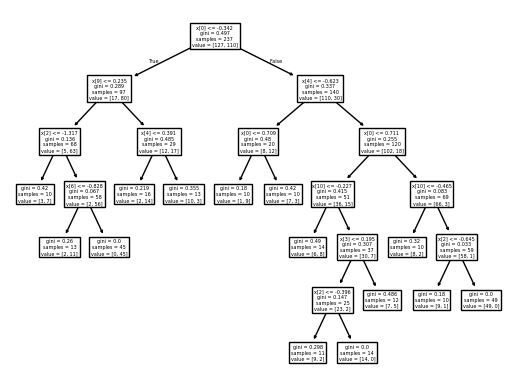

In [ ]:
# ---------------------------------------------------------------------------- #
#                                     MODEL                                    #
# ---------------------------------------------------------------------------- #

# Create model
model = tree.DecisionTreeClassifier(max_depth= 29, min_samples_split = 20, min_samples_leaf = 10, criterion = 'gini', random_state=Random_Seed)

# Train model
model.fit(train_X, train_y)

# Test model
y_pred = model.predict(test_X)

pred_probs = model.predict_proba(test_X)

# Evaluation:
acc = accuracy_score(test_y, y_pred)
roc_auc = roc_auc_score(test_y, pred_probs[:, 1])

print(f"Accuracy: {acc:.2f}")
print(f"AUC-ROC: {roc_auc:.2f}")

plot = tree.plot_tree(model)
#Best hyperparameters: {'max_depth': 29, 'min_samples_split': 20, 'min_samples_leaf': 10, 'criterion': 'gini'}